## Upsampling & Super-Resolution

- Convolution + Stride = Size Reduction = Feature Extraction/Compression
- Convolution + Pooling $\Rightarrow$ Size Reduced Image
- How to size up?
    1. Interpolation & Convolution: 
        - nn.Sequential(nn.Upsample(), nn.Conv2d())
        - Linear interpolation, the simplest.
        - Bilinear interpolation, Extension to 2D.
    1. Sub-Pixel Convolution (ESPCNN, CVPR2016)
        - Simply use nn.Conv2d()
        - The last convolution layer has the channel size equal to $r^2$, where $r$ is the scale factor.
        - nn.PixelShuffle() re-arrange ($C\times r^2,H,W$) to ($1,rH, rW$).
    1. Convolution Transposed
        - Conceptually, 1D explanation is easy. Above 1D seems tricky to explane, but we can ask for imagination.
        - Not popular these days, but does not mean it really performs bad.

## Single Image Super-Resolution by ESPCN
- [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolution Neural Network, IEEE CVPR 2016, W. Shi, F. Huszar, J. Totz, A. Aitken, R. Bishop, D. Rueckert, Z. Wang](https://arxiv.org/abs/1609.05158)
- [Pytorch code example in github.com/pytorch](https://github.com/pytorch/examples/tree/master/super_resolution)
- [github.com/atrimults/subpixels](https://github.com/atriumlts/subpixel) Worth visiting.

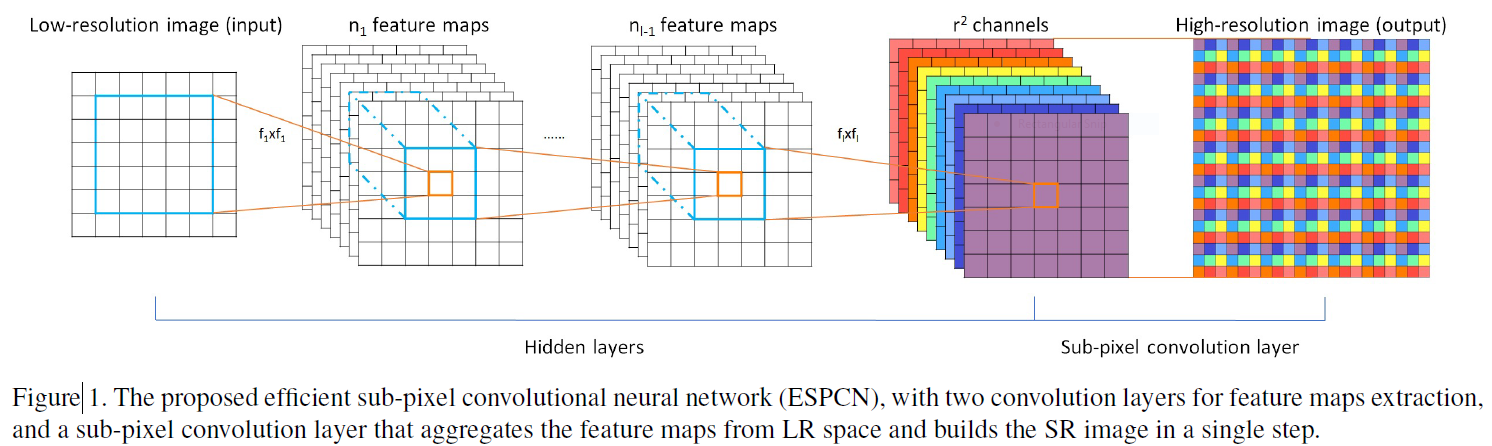

---
### Summary

- Images from [BDS300](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/) is used for training and testing.
    - It does not matter what dataset is used as long as we have some high definition digital images
    - BDS300 is a dataset to study image segmentation. 
        - Only the images are used here.
        - train/test split exists.
    - Now it has BDS500.
- The network is composed of pure Convolution layers (no upsampling/interpolation)
    - A trained network can be used for arbitrary size image. 
    - The scale factor $r$ must be a positive integer.
- Input/Target images:
    - Any chosen image is to be the target, and its $1/r$ scaled image is the input source:
        - Gaussian smoothing followed by sampling
- Loss function is simply MSE Loss: The smaller the better.
    - MSE
$$
L = \frac{1}{r^2 HW} \sum_x \sum_y \bigg(  I^\mathrm{HR}(x,y) - \hat{I}(x,y) \bigg), \quad\quad \hat{I} = \mathrm{Model}\big( I^\mathrm{LR} \big)
$$
    - PSNR
        - good to compare small scale changes
        - a log scaled version of MSE
        - the larger the better.
$$
    PSNR = 10 \log_{10}\bigg(\frac{1}{MSE}\bigg) = -10\log_{10}MSE
$$

---

### Example
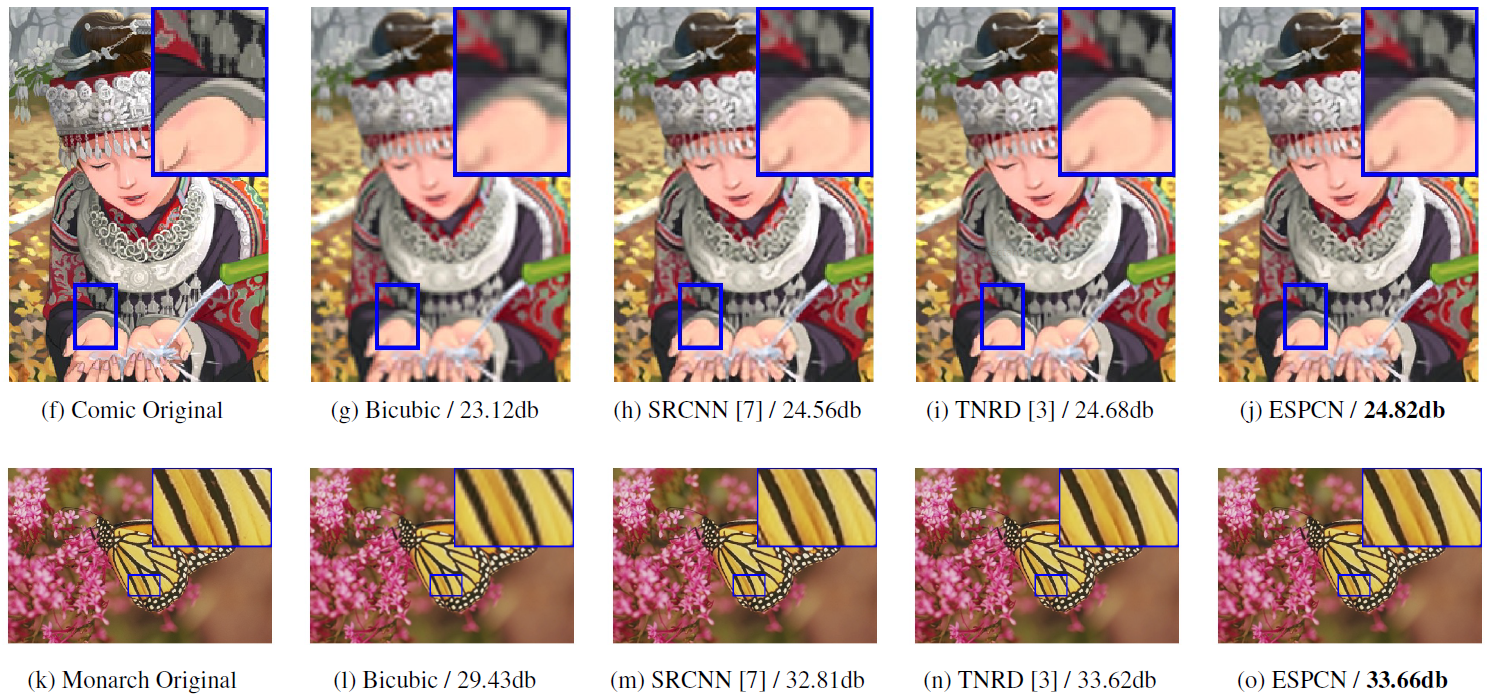

---
### Potential Applications to Generative Models and Models of High-Resolution Output
    - Conv-deconv autoencoders
    - Deep Convolutional Autoencoders (DCGAN)
    - Segmentation Networks (SegNets)

---
### Practicum
- Magnify with $r=4$.
    - Training can be done as many images as possible.
        - Keep BSD300 test images for validation. Report average PSNR.
    - Use any image of Full HD size.
    - Reduce the target image to 1/4 size. Use any image library: PIL, opencv, skimage
    - You may include more layers of $nn.Conv2d()$.
    - Prepare three images of super high-quality for test, which must be, for sure, not included in the training dataset.
        - select 200x100 rectangle sub-region and crop. This is the target.
        - decrease the size to 1/4 and apply the trained network.
        - Show the magnification result.
        - Use a resize function in PIL/OpenCV/skimage to magnify the low resolution input and show together.
        - Calculate PSNR to put in the title/caption.
    - Design a model with nn.BatchNorm2d() with the same number of conv2d layers.
        - Does the model has some improvement in any respect?
    - How about replacing ReLU with ELU?
    - How about BatchNorm2d() - ELU() combination?
    - With ResNet  architecture?
    - With DenseNet architecture?

---
### Network Model

In [3]:
# model.py
import torch
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):  # in old days, weight initialization was not implicitly defined.
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)
#

### dataset.py

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)
#

### data.py

In [9]:
from os.path import exists, join, basename
from os import makedirs, remove
from six.moves import urllib
import tarfile
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

#from dataset import DatasetFromFolder   # defined in dataset.py


def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))
#

---
### main.py

In [12]:
from __future__ import print_function
import argparse
import os
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#from model import Net
#from data import get_training_set, get_test_set

# Training settings
parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
parser.add_argument('--upscale_factor', type=int, required=True, help="super resolution upscale factor")
parser.add_argument('--batchSize', type=int, default=64, help='training batch size')
parser.add_argument('--testBatchSize', type=int, default=10, help='testing batch size')
parser.add_argument('--nEpochs', type=int, default=2, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.01, help='Learning Rate. Default=0.01')
parser.add_argument('--cuda', action='store_true', help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
opt = parser.parse_args()

print(opt)

if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)

device = torch.device("cuda" if opt.cuda else "cpu")

print('===> Loading datasets')
train_set = get_training_set(opt.upscale_factor)
test_set = get_test_set(opt.upscale_factor)
training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

print('===> Building model')
model = Net(upscale_factor=opt.upscale_factor).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=opt.lr)


def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))


def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


def checkpoint(epoch, output_path='.'):
    model_out_path = output_path + "/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))


# main loop -----------------------------------------------

output_path = 'model_epochs'
if not os.path.exists(output_path):
    os.makedirs(output_path)
print('@ outputs will be saved to: ', output_path)

for epoch in range(1, opt.nEpochs + 1):
    train(epoch)
    test()
    checkpoint(epoch, output_path)


usage: ipykernel_launcher.py [-h] [--upscale_factor UPSCALE_FACTOR]
                             [--batchSize BATCHSIZE]
                             [--testBatchSize TESTBATCHSIZE]
                             [--nEpochs NEPOCHS] [--lr LR] [--cuda]
                             [--threads THREADS] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\VIP\AppData\Roaming\jupyter\runtime\kernel-bc893a1e-fe53-4f9b-91a8-4eee6ffb2a1f.json


SystemExit: 2